In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def model_info(model, verbose=0):
    layer_info = []
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    trainable_layers, non_trainable_layers = 0, 0
    trainable_params, non_trainable_params = 0, 0
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        trainable = layer.trainable
        layer_type = type(layer).__name__
        data.append([i, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
        layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
        if trainable:
            trainable_params += layer_params
            trainable_layers += 1
        else:
            non_trainable_params += layer_params
            non_trainable_layers += 1
    print("=========================================================")
    print(f"Total params: {int(trainable_params + non_trainable_params):,}")
    print(f"Trainable params: {int(trainable_params):,}")
    print(f"Non-trainable params: {int(non_trainable_params):,}")
    print(f"Total layers: {len(model.layers):,}")
    print(f"Trainable layers: {trainable_layers:,}")
    print(f"Non-trainable params: {non_trainable_layers:,}")
    print("=========================================================")
    if verbose == 1:
        print(tabulate(data, headers=header, colalign="c", tablefmt="github"))

In [4]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}")    

In [5]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), max(plt.ylim())])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:
def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [7]:
PATH = "/content/drive/MyDrive/Datasets/data"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [10]:
callbacks_path = "/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/nasnet_models/"
model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")
fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

In [11]:
base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

19993432/19993432 [==============================] - 2s 0us/step


In [35]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  769


In [12]:
model_info(base_model, verbose=1)

Total params: 4,269,716
Trainable params: 4,269,716
Non-trainable params: 0
Total layers: 769
Trainable layers: 769
Non-trainable params: 0
|   Number | Name               | Input_shape                                                                                          | Output_shape   | Trainable   |
|----------|--------------------|------------------------------------------------------------------------------------------------------|----------------|-------------|
|          |                    |                                                                                                      |                |             |
| 0        | InputLayer         | []                                                                                                   | []             | True        |
| 1        | Conv2D             | (224, 224, 3)                                                                                        | (111, 111, 32) | True        |
| 2        | BatchNo

In [13]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

In [14]:
base_model.trainable = False

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2)
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 5e-4

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0     

In [20]:
initial_epochs = 20
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6291
Epoch 1: val_accuracy improved from -inf to 0.75909, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/nasnet_models/best_model.h5
83/83 [==============================] - 780s 8s/step - loss: 0.6378 - accuracy: 0.6291 - val_loss: 0.5197 - val_accuracy: 0.7591
Epoch 2/20
82/83 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7458
Epoch 2: val_accuracy improved from 0.75909 to 0.78333, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/nasnet_models/best_model.h5
83/83 [==============================] - 15s 173ms/step - loss: 0.5185 - accuracy: 0.7463 - val_loss: 0.4679 - val_accuracy: 0.7833
Epoch 3/20
82/83 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.7565
Epoch 3: val_accuracy improved from 0.78333 to 0.79545, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/n

In [21]:
print(history.history)

{'loss': [0.6377920508384705, 0.5184967517852783, 0.48606517910957336, 0.4591444134712219, 0.45278578996658325, 0.4421655535697937, 0.4250085949897766, 0.42773327231407166, 0.4151677191257477, 0.41800329089164734, 0.40607714653015137, 0.4136612117290497, 0.4045485258102417, 0.40886542201042175, 0.4048595130443573, 0.39171743392944336, 0.3820926249027252, 0.3888341784477234, 0.3790605962276459, 0.3850720524787903], 'accuracy': [0.6291239857673645, 0.746302604675293, 0.7561622858047485, 0.7842245101928711, 0.7804322838783264, 0.7940841913223267, 0.7963594794273376, 0.7952218651771545, 0.8100113868713379, 0.8009101152420044, 0.8081153035163879, 0.8058399558067322, 0.8130451440811157, 0.8111490607261658, 0.8138035535812378, 0.8156996369361877, 0.8248009085655212, 0.8191125988960266, 0.8210087418556213, 0.8145620226860046], 'val_loss': [0.5196507573127747, 0.4678725302219391, 0.44505536556243896, 0.43202224373817444, 0.42338547110557556, 0.4198513925075531, 0.41107574105262756, 0.4072082936

In [22]:
base_model.trainable = True

In [36]:
fine_layer_unfrize = 100

In [37]:
for i, layer in enumerate(base_model.layers[:-fine_layer_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-fine_layer_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [38]:
model_info(base_model)

Total params: 4,269,716
Trainable params: 877,008
Non-trainable params: 3,392,708
Total layers: 769
Trainable layers: 47
Non-trainable params: 722


In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [40]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs
fine_history = model.fit(train_dataset,
                        validation_data = validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], 
                         callbacks=[fine_model_checkpoint])

Epoch 20/40
82/83 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9120
Epoch 20: val_accuracy did not improve from 0.85152
83/83 [==============================] - 33s 177ms/step - loss: 0.2043 - accuracy: 0.9120 - val_loss: 0.3502 - val_accuracy: 0.8470
Epoch 21/40
83/83 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9120
Epoch 21: val_accuracy did not improve from 0.85152
83/83 [==============================] - 10s 119ms/step - loss: 0.1985 - accuracy: 0.9120 - val_loss: 0.3282 - val_accuracy: 0.8455
Epoch 22/40
82/83 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9207
Epoch 22: val_accuracy improved from 0.85152 to 0.85606, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/nasnet_models/best_model_fine.h5
83/83 [==============================] - 13s 149ms/step - loss: 0.1926 - accuracy: 0.9211 - val_loss: 0.3226 - val_accuracy: 0.8561
Epoch 23/40
83/83 [============================

In [41]:
print(fine_history.history)

{'loss': [0.20431700348854065, 0.1984604001045227, 0.19255030155181885, 0.19460730254650116, 0.18214447796344757, 0.18974165618419647, 0.17066553235054016, 0.1729072481393814, 0.16633917391300201, 0.1745026707649231, 0.1574162393808365, 0.15878397226333618, 0.1699441522359848, 0.1623624861240387, 0.1612895429134369, 0.15125782787799835, 0.15094570815563202, 0.15622219443321228, 0.14538680016994476, 0.13675841689109802, 0.13025827705860138], 'accuracy': [0.9120212197303772, 0.9120212197303772, 0.9211224913597107, 0.9203640222549438, 0.9271900057792664, 0.9173303246498108, 0.9271900057792664, 0.9264315366744995, 0.9279484152793884, 0.9287068843841553, 0.937808096408844, 0.9328782558441162, 0.9245354533195496, 0.935912013053894, 0.9230185747146606, 0.9400834441184998, 0.937808096408844, 0.935912013053894, 0.9381873607635498, 0.9431172013282776, 0.9461509585380554], 'val_loss': [0.35015472769737244, 0.32822108268737793, 0.32255321741104126, 0.3448485732078552, 0.3474299907684326, 0.3348589

In [42]:
get_history_stats(history.history)

Accuracy: 0.8248
Validation accuracy: 0.8212
Loss: 0.3791
Validation loss : 0.3848


In [43]:
get_history_stats(fine_history.history)

Accuracy: 0.9462
Validation accuracy: 0.8667
Loss: 0.1303
Validation loss : 0.3226


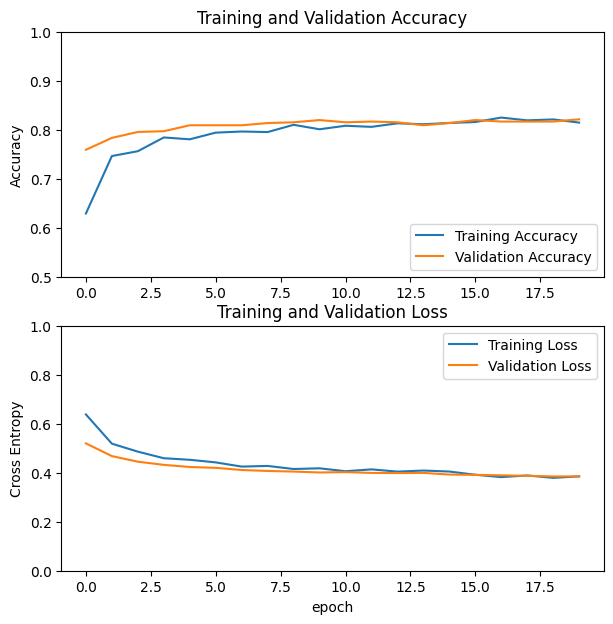

In [44]:
plot_hist(history.history)

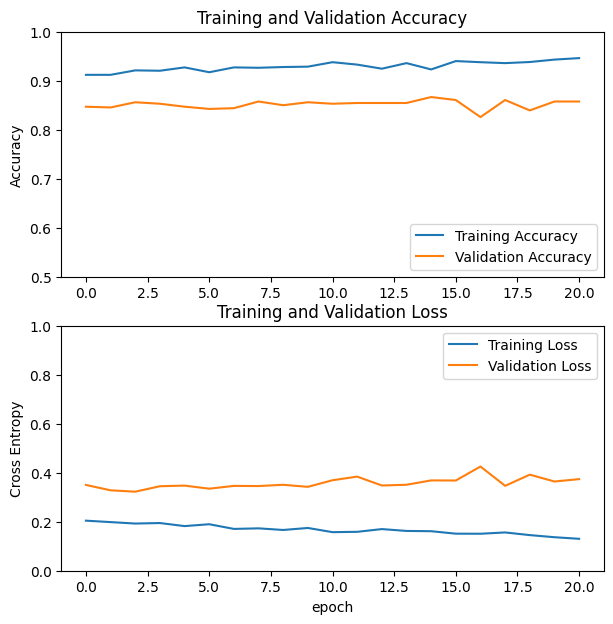

In [45]:
plot_hist(fine_history.history)

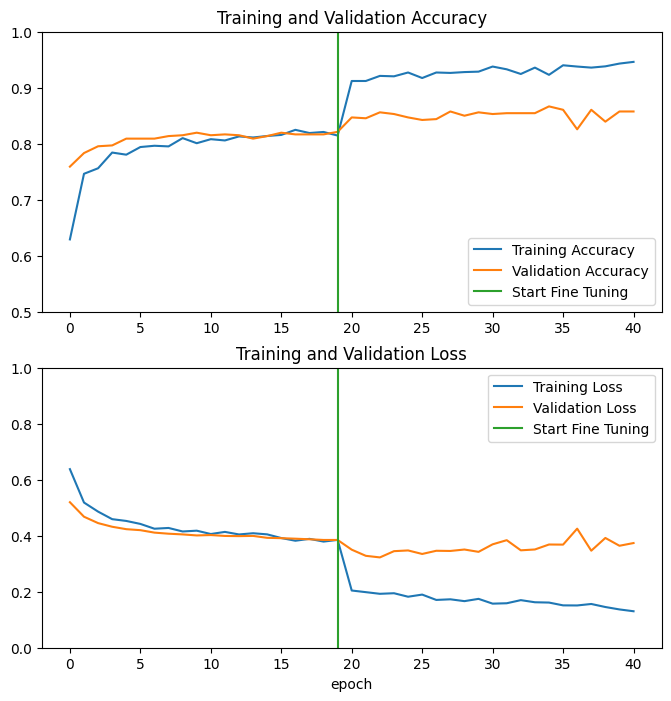

In [46]:
plot_total_hist(history.history, fine_history.history, fine_tune_epochs)